# SPICE Example 1 - Observing M2020 from HiRISE during EDL #
Here we'll derive a few things about the upcoming EDL image that HiRISE will take. We start by importing the SpiceyPy module and other useful things.

> Annex et al., (2020). SpiceyPy: a Pythonic Wrapper for the SPICE Toolkit. Journal of Open Source Software, 5(46), 2050, https://doi.org/10.21105/joss.02050

Things we'll learn about SPICE (and SpicyPy) here:
* Loading kernels
* Time conversions
* Finding body positions
* Finding subobserver points
* Intersect instrument boresites with ellipsoids
* Mapping targets back into instrument pixels
* Phase angles, target distances, etc...

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import spiceypy as spice
from mpl_toolkits.mplot3d import Axes3D

kernel_home = "/Users/shane/Desktop/PTYS_551_code/PTYS_551_kernels/"

Several generic kernels are almost always needed.
* A planetary constants that contains info on the size, shape and coordinate system of planetary objects.
* A leap seconds kernel is required for almost all time conversions.
* A frames kernel for MRO describes how all the instruments are mounted on the spacecraft. We also add the HiRISE instrument kernel, and the MRO spacecraft clock kernel.

In [5]:
spice.furnsh(kernel_home+"M2020_EDL/pck00010.tpc")
spice.furnsh(kernel_home+"M2020_EDL/naif0012.tls")
spice.furnsh(kernel_home+"M2020_EDL/mro_v15.tf")
spice.furnsh(kernel_home+"M2020_EDL/mro_hirise_v12.ti")
spice.furnsh(kernel_home+"M2020_EDL/MRO_SCLKSCET.00090.tsc")

Both spacecraft are moving so we need an SPK kernel for each one. If any quantities relative to Mars are needed then we need an SPK kernel that describes Mars' position as well.

In [6]:
#spice.furnsh(kernel_home+"M2020_EDL/mar097.bsp")
spice.furnsh(kernel_home+"M2020_EDL/de440s.bsp")
spice.furnsh(kernel_home+"M2020_EDL/m2020_trajCEDLS-6DOF_ops_od020v1_AL23.bsp")
spice.furnsh(kernel_home+"M2020_EDL/spk_psp_20210211-20210502_20200908_ERTF6_M2020EDL.bsp")

MRO's orientation clearly matters, so we'll need a CK for that.

In [7]:
spice.furnsh(kernel_home+"M2020_EDL/CK_Pred_MRO_M20_ERTF6a_sc_20201006194202.bc")

The target image time is provided by the same folks that provided the CK (LMA). They produce the commands to orientate and slew MRO in a way that makes M2020 pass through the field of view of HiRISE at the right rate. SPICE works in ephemeris time so we'll convert the UTC time provided to ephemeris time.

We typically want to recover solutions in a time range about the point of interest so we can figure out if everything is behaving as expected. So I'm setting up an array of times that's centered on the image time, 7200 seconds wide, and spaced every 0.1 sec. 

In [8]:
tot    = "2021-FEB-18 20:42:50.155"
et_tot = spice.utc2et(tot)

win  = 7200.0                                          # Time window size to do the analysis in (centered on image time)
dt   = 0.1                                             # Time interval between geometry calculations
et   = np.arange(et_tot-win/2, et_tot+win/2, dt)

Let's check the times make sense... Check out MRO's and M2020's position relative to Mars. Two hours is about one MRO-orbit, so we should see an ellipse for MRO and a direct entry for M2020

In [9]:
[pos,  ltime]  = spice.spkpos('MRO', et, 'J2000', 'LT+S', 'MARS')
[pos2, ltime]  = spice.spkpos('-168', et, 'J2000', 'LT+S', 'MARS')

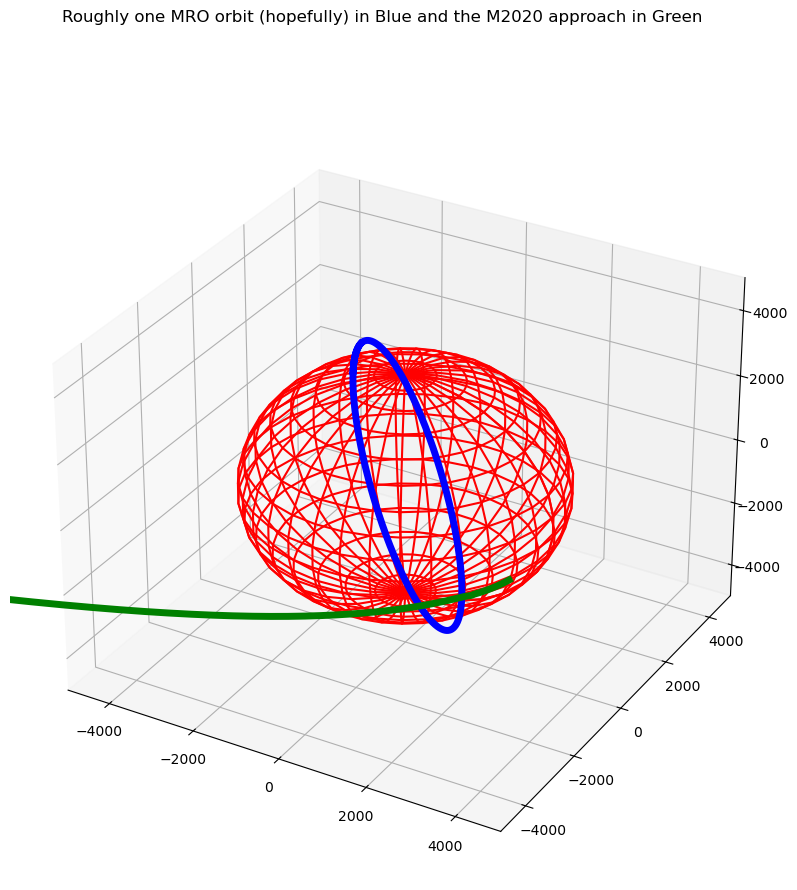

In [10]:
# Make Mars Surface data
u = np.linspace(0, 2 * np.pi, 36)
v = np.linspace(0, np.pi, 18)
xmars = 3396.19 * np.outer(np.cos(u), np.sin(v))
ymars = 3396.19 * np.outer(np.sin(u), np.sin(v))
zmars = 3396.19 * np.outer(np.ones(np.size(u)), np.cos(v))


fig = plt.figure(figsize=(10,10))
fig.suptitle('Roughly one MRO orbit (hopefully) in Blue and the M2020 approach in Green')
ax  = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(xmars, ymars, zmars, color='red')
ax.set_xlim3d(-5000, 5000)
ax.set_ylim3d(-5000, 5000)
ax.set_zlim3d(-5000, 5000)

ax.plot(pos[:,0],pos[:,1],pos[:,2],color='Blue',lw=5,zorder=13)
ax.plot(pos2[:,0],pos2[:,1],pos2[:,2],color='green',lw=5,zorder=13)
plt.show()

Looks good so far! What about the groundtrack of the two spacecraft and where HiRISE is looking?
Groundtracks and intersections of camera boresights can be found if you can guess the names of all the frames, spacecraft, bodies etc... The MRO_HIRISE_LOOK_DIRECTION frame is set up so that the z-axis is the boresight (+z, [0,0,1], pointing out of the instrument).

In [11]:
[num, radii] = spice.bodvrd('MARS', 'RADII', 3)  # Retrieve Mars Radii to help conversion to lat/lon

mro_lon   = np.zeros(len(et))
mro_lat   = np.zeros(len(et))
m2020_lon = np.zeros(len(et))
m2020_lat = np.zeros(len(et))
hirise_lon = np.zeros(len(et))
hirise_lat = np.zeros(len(et))


with spice.no_found_check():
    for i in range(0,len(et)):
        [spoint, trgepc, srfvec] = spice.subpnt('Intercept/ellipsoid', 'MARS', et[i], 'IAU_MARS', 'LT+S', 'MRO' )
        [mro_lon1, mro_lat1, mro_alt1] = spice.recpgr('MARS', spoint, radii[0], (radii[0]-radii[2])/radii[0])
        mro_lon[i] = 360.0 - mro_lon1 * 180.0/np.pi
        mro_lat[i] = mro_lat1 * 180.0/np.pi

        [spoint, trgepc, srfvec] = spice.subpnt('Intercept/ellipsoid', 'MARS', et[i], 'IAU_MARS', 'LT+S', '-168' )
        [m2020_lon1, m2020_lat1, m2020_alt1] = spice.recpgr('MARS', spoint, radii[0], (radii[0]-radii[2])/radii[0])   
        m2020_lon[i] = 360.0 - m2020_lon1 * 180.0/np.pi
        m2020_lat[i] = m2020_lat1 * 180.0/np.pi
    
        [spoint, trgepc, srfvec, f] = spice.sincpt('ELLIPSOID','MARS',et[i], 'IAU_MARS', 'LT+S','MRO','MRO_HIRISE_LOOK_DIRECTION',[0,0,1])
        [hirise_lon1, hirise_lat1, hirise_alt1] = spice.recpgr('MARS', spoint, radii[0], (radii[0]-radii[2])/radii[0])
        hirise_lon[i] = 360.0 - hirise_lon1 * 180.0/np.pi
        hirise_lat[i] = hirise_lat1 * 180.0/np.pi

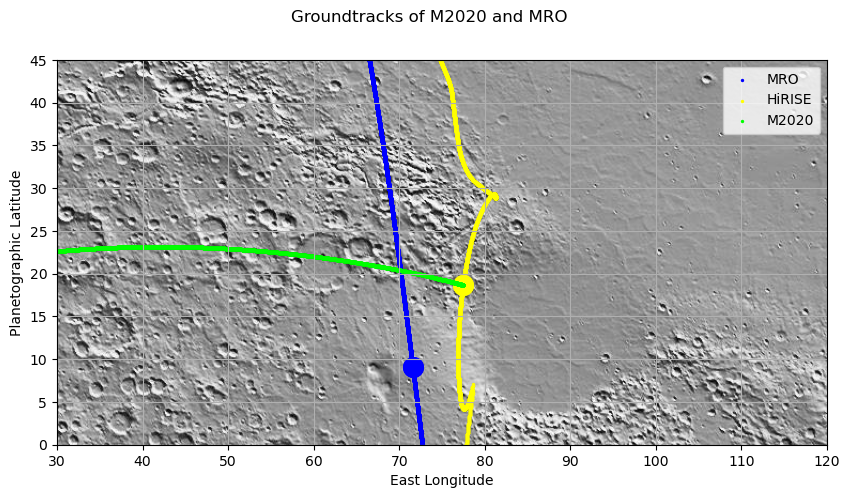

In [12]:
bg = plt.imread('ced2880x1440.jpg')

fig, ax = plt.subplots(1,1,figsize=(10,5))
fig.suptitle('Groundtracks of M2020 and MRO')
ax.imshow(bg, extent=[0,360, -90,90])
ax.imshow(bg, extent=[-360,0, -90,90])

ax.scatter(mro_lon,mro_lat,color='#0000ff',s=2,label='MRO')
ax.scatter(mro_lon-360,mro_lat,color='#0000ff',s=2)
ax.scatter(hirise_lon,hirise_lat,color='#ffff00',s=2,label='HiRISE')
ax.scatter(hirise_lon-360.0,hirise_lat,color='#ffff00',s=2)
ax.scatter([mro_lon[36000],mro_lon[36000]],[mro_lat[36000],mro_lat[36000]],color='#0000ff',s=200)
ax.scatter([hirise_lon[36000],hirise_lon[36000]],[hirise_lat[36000],hirise_lat[36000]],color='#ffff00',s=200)

ax.scatter(m2020_lon,m2020_lat,color='#00ff00',s=2,label='M2020')
ax.scatter(m2020_lon-360.0,m2020_lat,color='#00ff00',s=2)

#ax.scatter([77,77],[18.56,18.56],s=500,alpha=0.5,c='#ff0000')

ax.set_xlabel('East Longitude')
ax.set_ylabel('Planetographic Latitude')
ax.set_ylim(-90,90)
ax.set_xlim(77-180,77+180)

ax.set_ylim(0,45)
ax.set_xlim(30,120)

ax.legend()
ax.grid(True)

Looks good! Spacecraft positions and instrument look-vectors seem like they're behaving!

With all this set up, we can initialize some arrays to hold the answers we're looking for in planning this overvation. We loop through all the times and recover the vectors from M2020 to the Sun, from M2020 to MRO, and from MRO to M2020. As we've requested the light-time correction, these vectors are towards the apparent position of that object at the time. That means the vector from M2020 to MRO is **not** the inverse of the vector from MRO to M2020!

In [13]:
phase = np.zeros(len(et))
dis   = np.zeros(len(et))
vx    = np.zeros(len(et))
vy    = np.zeros(len(et))

for i in range(0,len(et)):
    [starg_sun, ltime] = spice.spkez(10, et[i], 'J2000', 'LT+S', -168)                   # Recover vector from M2020 to the Sun
    unit_sun    = starg_sun[0:3] / np.sqrt(np.sum(np.power(starg_sun[0:3],2)))           # Convert to a unit vector

    [starg_mro, ltime] = spice.spkez(-74, et[i], 'J2000', 'LT+S', -168)                  # Recover vector from M2020 to MRO
    unit_mro    = starg_mro[0:3] / np.sqrt(np.sum(np.power(starg_mro[0:3],2)))           # Convert to a unit vector     

    [starg_m2020, ltime] = spice.spkez(-168, et[i], 'J2000', 'LT+S', -74)                # Recover vector from MRO to M2020 
    unit_m2020  = starg_m2020[0:3] / np.sqrt(np.sum(np.power(starg_m2020[0:3],2)))       # Convert to a unit vector     

    rot = spice.pxform('J2000','MRO_HIRISE_LOOK_DIRECTION', et[i])                       # Find how to rotate from J2000 to HiRISE at this time
    vec = np.matmul(rot,unit_m2020)
    vx[i] = -np.arctan(vec[1]/vec[2]) * 1e6                                              # Use pinhole optics aprox to find position on focal plane
    vy[i] = -np.arctan(vec[0]/vec[2]) * 1e6                                              # Factor of 10^6 converts from radians to pixels (roughly)
    
    phase[i]    = np.arccos(np.sum(unit_sun*unit_mro)) * 180.0/np.pi                     # Use dot product to find angle between vector to MRO and vector to the Sun
    dis[i]      = np.sqrt(np.sum(np.power(starg_m2020[0:3],2)))                          # Magnitude of the vector from MRO to M2020   
    

(-20.0, 20.0)

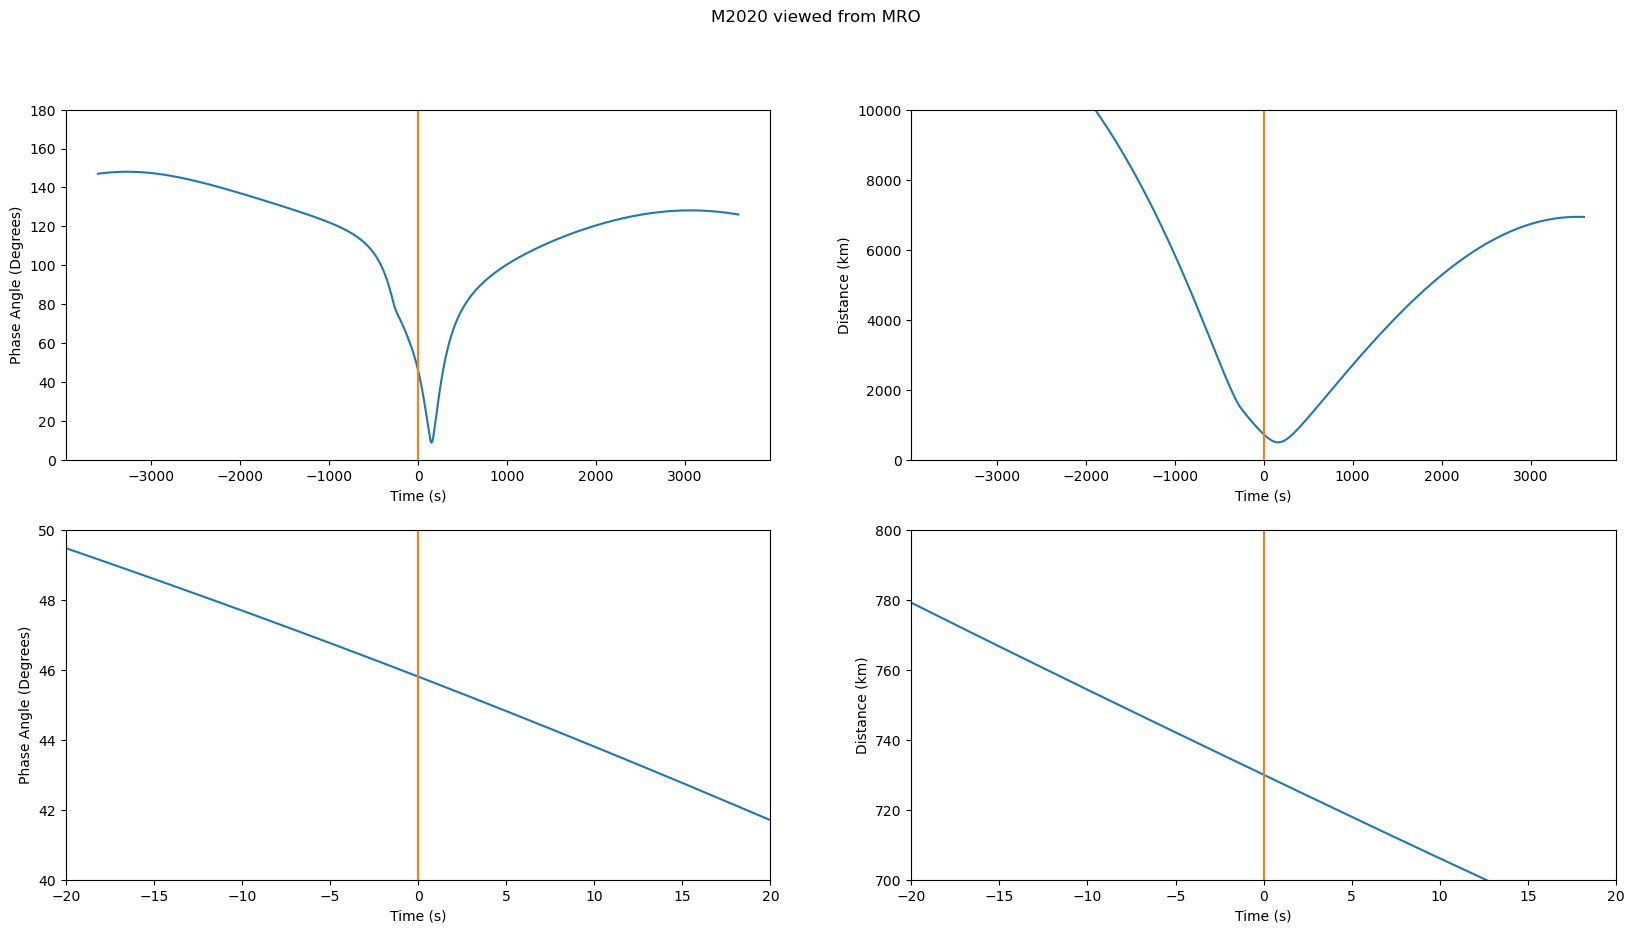

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(20, 10))
fig.suptitle('M2020 viewed from MRO')

ax1.plot(et-et_tot, phase)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Phase Angle (Degrees)')
ax1.plot([0,0],[0,180])
ax1.set_ylim(0,180)

ax2.plot(et-et_tot, dis)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Distance (km)')
ax2.plot([0,0],[0,10000])
ax2.set_ylim(0,10000)

ax3.plot(et-et_tot, phase)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Phase Angle (Degrees)')
ax3.plot([0,0],[0,180])
ax3.set_ylim(40,50)
ax3.set_xlim(-20,20)

ax4.plot(et-et_tot, dis)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Distance (km)')
ax4.plot([0,0],[0,10000])
ax4.set_ylim(700,800)
ax4.set_xlim(-20,20)

HiRISE is very concerned about the rate of slew so the image exposure can be planned properly. 

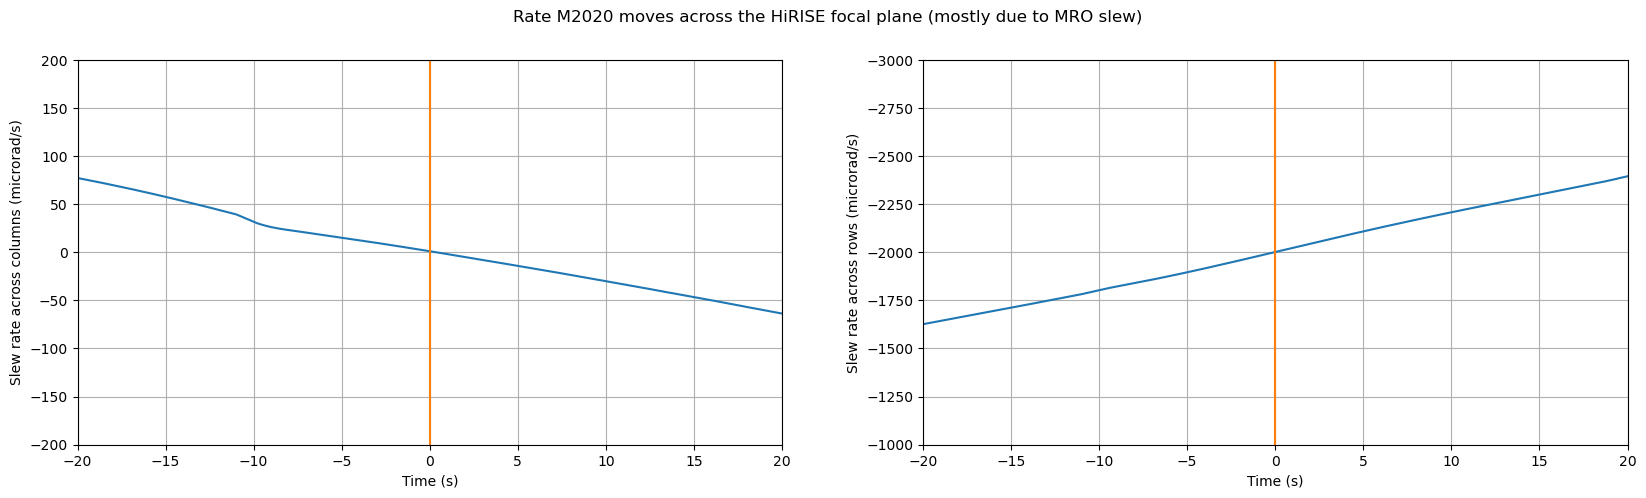

In [17]:
dvy = (vy-np.roll(vy,-1)) / dt           # Angular velocity in the y-direction (microrad/s)
dvx = (vx-np.roll(vx,-1)) / dt           # Angular velocity in the x-direction (microrad/s)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 5))
fig.suptitle('Rate M2020 moves across the HiRISE focal plane (mostly due to MRO slew)')

ax1.plot(et-et_tot, dvx)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Slew rate across columns (microrad/s)')
ax1.plot([0,0],[-10000,10000])
ax1.set_ylim(-200,200)
ax1.set_xlim(-20,20)
ax1.grid(True)

ax2.plot(et-et_tot, dvy)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Slew rate across rows (microrad/s)')
ax2.plot([0,0],[-10000,10000])
ax2.set_ylim(-1000,-3000)
ax2.set_xlim(-20,20)
ax2.grid(True)






# Check out the final image!!

![M2020 EDL](mars2020-context-final.jpg)